In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import numpy as np
import random
from easydict import EasyDict as edict
from matplotlib import pyplot as plt
import torch, torch.nn as nn

from iterative_sir.toy_examples_utils.gan_fc_models import (Generator_fc, 
                           Discriminator_fc)

from iterative_sir.sampling_utils.distributions import (
                           GaussianMixture, 
                           IndependentNormal)

from iterative_sir.toy_examples_utils.params_25gaussians_wasserstein import (sigma,
                                random_seed,
                                train_dataset_size,
                                n_dim,
                                n_layers_d,
                                n_layers_g,
                                n_hid_d,
                                n_hid_g,
                                n_out,
                                device)


In [50]:
import seaborn as sns
sns.set_theme(style="ticks", palette="deep")

In [51]:
from pathlib import Path
figpath = Path('../figs')

In [52]:
import itertools

def prepare_100gaussian_data(batch_size=1000, sigma=0.05, random_seed=42):
    dataset = []
    for i in range(batch_size // 100):
        for x in np.arange(-2, 2.5, 0.5):
            for y in np.arange(-2, 2.5, 0.5):
                point = np.random.randn(2) * sigma
                point[0] += x
                point[1] += y
                dataset.append(point)
    dataset = np.array(dataset, dtype=np.float32)
    np.random.seed(random_seed)
    random.seed(random_seed)
    np.random.shuffle(dataset)
    means = np.array(
        list(itertools.product(np.arange(-2, 2.5, 0.5), repeat=2)),
        dtype=np.float64,
    )
    return dataset, means

In [53]:
from sklearn.preprocessing import StandardScaler

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

X_train, means = prepare_100gaussian_data(train_dataset_size,
                                         sigma / 2., 
                                         random_seed)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [54]:
G = Generator_fc(n_dim=n_dim, 
                 n_layers=n_layers_g,
                 n_hid=n_hid_g,
                 n_out=n_out,
                 non_linear=nn.ReLU(),
                 device=device)
D = Discriminator_fc(n_in=n_dim, 
                     n_layers=n_layers_d,
                     n_hid=n_hid_d,
                     non_linear=nn.ReLU(),
                     device=device)

In [55]:
models_2d_path = '../models/models_100gaussians'

dics_path = sorted(Path(models_2d_path).glob('*4_discriminator.pth'))[-1]
gen_path = sorted(Path(models_2d_path).glob('*4_generator.pth'))[-1]

G.load_state_dict(torch.load(gen_path, map_location=device))
D.load_state_dict(torch.load(dics_path, map_location=device))

G = G.to(device)
D = D.to(device)
G.eval()
D.eval()
G.z_dim = G.n_dim

In [56]:
n_dim = G.n_dim
loc = torch.zeros(n_dim).to(G.device)
scale = torch.ones(n_dim).to(G.device)
normalize_to_0_1 = True 
log_prob = True

proposal_args = edict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(dim=n_dim, **proposal_args)

# target_gan = partial(gan_energy, 
#                      generator = G, 
#                      discriminator = D, 
#                      proposal = proposal,
#                      normalize_to_0_1 = normalize_to_0_1,
#                      log_prob = log_prob)

In [57]:
n_pts_ax = 100
n_kde_pts = 50000
latent_grid = np.meshgrid(np.linspace(-3, 3, n_pts_ax), np.linspace(-3, 3, n_pts_ax))
real_grid = np.meshgrid(np.linspace(-2.2, 2.2, n_pts_ax), np.linspace(-2.2, 2.2, n_pts_ax))

In [58]:
#zs = np.stack(latent_grid, -1).reshape(-1, n_dim)

zs = np.random.randn(n_kde_pts, n_dim)
xs_normalized = G(torch.from_numpy(zs).float()).detach().numpy()
xs = scaler.inverse_transform(xs_normalized)
dgz = D(torch.from_numpy(xs_normalized)).squeeze()

reals = np.stack(real_grid, -1).reshape(-1, n_dim)
dgz_ = D(torch.from_numpy(scaler.transform(reals)).float()).squeeze()

#log_prob = proposal.log_prob(torch.from_numpy(zs)).squeeze()
#energy = (log_prob + dgz).detach().numpy()
# energy = -(dgz).detach().numpy()
# #energy = (log_prob).detach().numpy()
# energy_grid = energy.reshape(n_pts_ax, n_pts_ax)

In [59]:
import scipy.stats as stats

kde = stats.kde.gaussian_kde(xs.transpose(1, 0))#, bw_method=0.06)
#log_probs = kde.logpdf(xs.transpose(1, 0))
log_probs = kde.logpdf(reals.transpose(1, 0))


In [60]:
energy = (log_probs + dgz_.detach().numpy())
energy_grid = energy.reshape(n_pts_ax, n_pts_ax)

In [61]:
from  pathlib import Path
Path('../figs/100gaussians').mkdir(exist_ok=True)

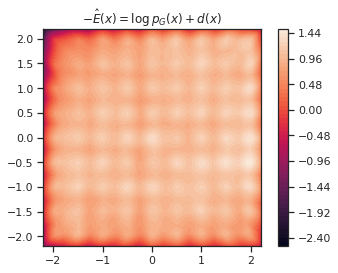

In [62]:
# xs_grid = xs.reshape(n_pts_ax, n_pts_ax, 2)
xs_grid = reals.reshape(n_pts_ax, n_pts_ax, 2)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.contourf(xs_grid[..., 0], xs_grid[..., 1], energy_grid, levels=50)
fig.colorbar(im)
ax.set_aspect('equal')
plt.title(r'$-\hat{E}(x) = \log p_G(x) + d(x)$')
plt.savefig(Path('../figs/100gaussians', 'minus_energy_sigma_0.025.png'))

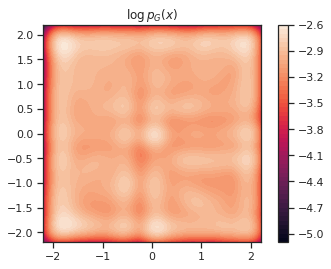

In [63]:
# xs_grid = xs.reshape(n_pts_ax, n_pts_ax, 2)
xs_grid = reals.reshape(n_pts_ax, n_pts_ax, 2)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.contourf(xs_grid[..., 0], xs_grid[..., 1], log_probs.reshape(n_pts_ax, n_pts_ax), levels=50)
fig.colorbar(im)
ax.set_aspect('equal')
plt.title(r'$\log p_G(x)$')
plt.savefig(Path('../figs/100gaussians', 'log_prob_0.025.png'))

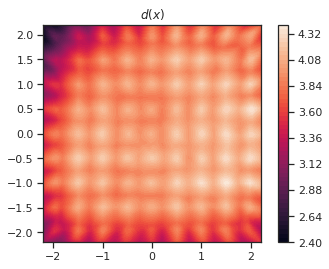

In [64]:
# xs_grid = xs.reshape(n_pts_ax, n_pts_ax, 2)
xs_grid = reals.reshape(n_pts_ax, n_pts_ax, 2)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.contourf(xs_grid[..., 0], xs_grid[..., 1], dgz_.detach().numpy().reshape(n_pts_ax, n_pts_ax), levels=50)
fig.colorbar(im)
ax.set_aspect('equal')
plt.title(r'$d(x)$')
plt.savefig(Path('../figs/100gaussians', 'dgz_0.025.png'))

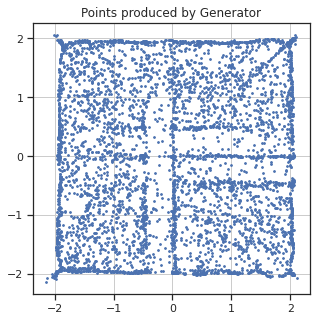

In [65]:
zs = proposal.sample((5000,))
xs_normalized = G(zs).detach().numpy()
xs = scaler.inverse_transform(xs_normalized)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.scatter(xs[:, 0], xs[:, 1], s=3)
ax.set_aspect('equal')
plt.grid()
plt.title('Points produced by Generator')
plt.savefig(Path('../figs/100gaussians', 'gen_0.025.png'))